In [40]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap

import astropy.coordinates as coord
import astropy.units as u
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
coord.galactocentric_frame_defaults.set('v4.0')
pot = gp.MilkyWayPotential()

matplotlib.rc('xtick', labelsize=22, direction='in') 
matplotlib.rc('ytick', labelsize=22, direction='in')
lable_size = 24

import sklearn
# print(sklearn.__version__)
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import hdbscan

import warnings
warnings.filterwarnings("once")

In [41]:
fontsize = 18
m_h_list = ['m_h_g2','m_h_16','m_h_ap','m_h_r6c','m_h_l6s','m_h_gl3']
m_h_err_list = ['m_h_err_g2','m_h_err_16','m_h_err_ap','m_h_err_r6c','m_h_err_l6s','m_h_err_gl3']
m_h_flg_list = ['m_h_flg_g2','m_h_flg_16','m_h_flg_ap','m_h_flg_r6c','m_h_flg_l6s','m_h_flg_gl3']
alpha_m_list = ['alpha_m_g2','alpha_m_16','alpha_m_ap','alpha_m_r6c','alpha_m_l6s','alpha_m_gl3']
alpha_m_err_list = ['alpha_m_err_g2','alpha_m_err_16','alpha_m_err_ap','alpha_m_err_r6c','alpha_m_err_l6s','alpha_m_err_gl3']
alpha_m_flg_list = ['alpha_m_flg_g2','alpha_m_flg_16','alpha_m_flg_ap','alpha_m_flg_r6c','alpha_m_flg_l6s','alpha_m_flg_gl3']
color_list = ['k','r','g','y','c','m']
dataset_list = ['GaiaDR2','SDSSDR16','APOGEE','RAVEDR6','LAMOSTDR6LRSSTELLAR','GALAHDR3']

In [42]:
# Define a plotting funciton for plotting specific lists of stars in all relevant spaces
def plot_summary(df_vel,df_orb,ind_list,c_list,title,legends,list_mask=False,filename=None,bg=False,ds=True,ind_add_cut=[]):
    if len(ind_add_cut) == 0:
        ind_add_cut = ind_cut
    
    f = plt.figure(figsize=[40,30])
    
    plt.suptitle(title,fontsize=lable_size)
    
    # Set the plotting parameters
    plt.subplot(3,4,1)
    plt.xlim([-13000,-3000])
    plt.ylim([-5000,5000])
    plt.xlabel('X [pc]',fontsize=lable_size)
    plt.ylabel('Y [pc]',fontsize=lable_size)
    
    # Make a fake dot for the legend
    for i in range(len(ind_list)):
        if ((len(ind_list[i]) < 0.1*len(df_vel)) or (len(ind_list) == 1)) and bg == False:
            mkr='*'
            ec='k'
        else:
            mkr='.'
            ec=c_list[i][0]
        try:
            # Check if needs downsampling; if so, flag it in legend
            if len(ind_list[i]) > 5000 and ds == True:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i]+'_sp',marker=mkr,edgecolors=ec)
            else:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i],marker=mkr,edgecolors=ec)
        except IndexError:
            print("Cluster number:",legends[i],'has zero stars.')
    plt.legend(fontsize=lable_size-10)
    
    plt.subplot(3,4,5)
    plt.xlim([-13000,-3000])
    plt.ylim([-5000,5000])
    plt.xlabel('X [pc]',fontsize=lable_size)
    plt.ylabel('Z [pc]',fontsize=lable_size)
    
    plt.subplot(3,4,9)
    plt.xlim([-5000,5000])
    plt.ylim([-5000,5000])
    plt.xlabel('Y [pc]',fontsize=lable_size)
    plt.ylabel('Z [pc]',fontsize=lable_size)
    
    plt.subplot(3,4,2)
    plt.xlim([-450,450])
    plt.ylim([-450,450])
    plt.xlabel(r'$v_{r}$ [km/s]',fontsize=lable_size)
    plt.ylabel(r'$v_{\phi}$ [km/s]',fontsize=lable_size)
    
    plt.subplot(3,4,6)
    plt.xlim([-450,450])
    plt.ylim([-450,450])
    plt.xlabel(r'$v_{r}$ [km/s]',fontsize=lable_size)
    plt.ylabel(r'$v_{z}$ [km/s]',fontsize=lable_size)
    
    plt.subplot(3,4,10)
    plt.xlim([-450,450])
    plt.ylim([-450,450])
    plt.xlabel(r'$v_{\phi}$ [km/s]',fontsize=lable_size)
    plt.ylabel(r'$v_{z}$ [km/s]',fontsize=lable_size)
    
    plt.subplot(3,4,3)
    plt.xlim([-4.5e3,4.5e3])
    plt.ylim([-2.25e5,0.5e5])
    plt.xlabel(r'$L_z$ [kpc km s$^{-1}$]',fontsize=lable_size)
    plt.ylabel(r'$E_{tot}$ [km^2 s$^{-2}$]',fontsize=lable_size)
    
    plt.subplot(3,4,7)
    plt.xlim([-3.1,1.0])
    plt.ylim([-0.21,0.61])
    plt.xlabel('[Fe/H] [dex]',fontsize=lable_size)
    plt.ylabel(r'[$\alpha$/Fe] [dex]',fontsize=lable_size)
    
    plt.subplot(3,4,11)
    plt.xlabel('PCA x',fontsize=lable_size)
    plt.ylabel('PCA y',fontsize=lable_size)
    
    plt.subplot(3,4,4)
    plt.xlabel(r'$J_{\phi}/J_{tot}$ [kpc km/s]',fontsize=lable_size)
    plt.ylabel(r'$(J_z-J_R)/J_{tot}$ [kpc km/s]',fontsize=lable_size)
    
    plt.subplot(3,4,8)
    plt.xlim([-3.1,1.0])
    plt.xlabel('[Fe/H] [dex]',fontsize=lable_size)
    plt.ylabel('Count',fontsize=lable_size)
    
#     plt.subplot(3,4,12)
#     plt.xlim([-0.21,0.61])
#     plt.xlabel(r'[$\alpha$/Fe] [dex]',fontsize=lable_size)
#     plt.ylabel('Count',fontsize=lable_size)
    
    plt.subplot(3,4,12)
    plt.xlim([0,1])
    plt.xlabel('Eccentricity',fontsize=lable_size)
    plt.ylabel('Count',fontsize=lable_size)
    
    for i in range(len(ind_list)):
        if list_mask == True:
            ind = ind_add_cut[ind_list[i]]
        else:
            ind = ind_list[i]
        color = c_list[i]
        
        if (len(ind) < 0.1*len(df_vel) or (len(ind_list) == 1)) and bg == False:
            mkr='*'
            ms=100
            al=1 
            ec=['k']*len(ind)
        else:
            mkr='.'
            ms=10
            al=0.1
            ec=color
        
        # Determine if there are more than 10000 data points, if so, down-sample it
        if len(ind) > 5000 and ds == True:
            ii = np.random.choice(len(ind),int(len(ind)/20),replace=False)
            ind = ind[ii]
            
            # Check to see if color list also needs to be downsampled
            if len(color) > len(ind): 
                color = color[ii]
        
        # Plot Y vs. X
        plt.subplot(3,4,1)
        plt.scatter(df_vel.loc[ind,'XGC'],df_vel.loc[ind,'YGC'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=i)
        
        # Plot Z vs. X
        plt.subplot(3,4,5)
        plt.scatter(df_vel.loc[ind,'XGC'],df_vel.loc[ind,'ZGC'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=i)
        
        # Plot Z vs. Y
        plt.subplot(3,4,9)
        plt.scatter(df_vel.loc[ind,'YGC'],df_vel.loc[ind,'ZGC'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=i)
        
        
        # Plot vphi vs. vr
        plt.subplot(3,4,2)
        plt.scatter(df_vel.loc[ind,'best_vr'],df_vel.loc[ind,'best_vphi'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=i)
        
        
        # Plot vz vs. vr
        plt.subplot(3,4,6)
        plt.scatter(df_vel.loc[ind,'best_vr'],df_vel.loc[ind,'best_vz'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=i)
        
        
        # Plot vz vs. vphi
        plt.subplot(3,4,10)
        plt.scatter(df_vel.loc[ind,'best_vphi'],df_vel.loc[ind,'best_vz'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=i)
        
        
        # Plot Etot vs. Lz
        plt.subplot(3,4,3)
        plt.scatter(df_orb.loc[ind,'Lz'],df_orb.loc[ind,'Etot'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=i)
        
        
        # Plot Alpha vs. [Fe/H]
        plt.subplot(3,4,7)
        plt.scatter(df_vel.loc[ind,'m_h_ap'],df_vel.loc[ind,'alpha_m_ap'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=i)
        
        # Plot PCA
        plt.subplot(3,4,11)
        plt.scatter(df_orb.loc[ind,'PCA_X'],df_orb.loc[ind,'PCA_Y'],alpha=al,s=ms,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=i)
        plt.xlim([-5,5])
        plt.ylim([-5,5])
        
        # Plot Action diamond
        plt.subplot(3,4,4)
        plt.scatter(df_orb.loc[ind,'diamond_x'],df_orb.loc[ind,'diamond_y'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=i)
        
        # Plot the [Fe/H] histogram
        plt.subplot(3,4,8)
        plt.hist(df_vel.loc[ind,'m_h_ap'],histtype='step',bins=np.arange(-3.1,1.0,0.1))
        
        # Plot the [Alpha/Fe] histogram
#         plt.subplot(3,4,12)
#         plt.hist(df_vel.loc[ind,'alpha_m_ap'],histtype='step',bins=np.arange(-0.21,0.61,0.1))
        
        # Plot the eccentricity histogram (do only one of eccentricity and alpha)
        plt.subplot(3,4,12)
        plt.hist(df_orb.loc[ind,'ecc'],histtype='step',bins=np.arange(0.0,1,0.05))
        
    plt.show()
    if filename != None:
        f.savefig(filename)

In [6]:
# Import data
cm_vel_all = pd.read_hdf('../data/dr3_near_good_cm_vel_plxzp.h5')
cm_summary_all = pd.read_hdf('../data/dr3_near_good_cm_summary.h5')
orb_param_all = pd.read_hdf('../data/dr3_orb_param_bad_redo_merge.h5')

In [16]:
vel_g2 = pd.read_hdf('../data/dr3_near_vel_plxzp_g2_only.h5')

In [17]:
vel_g2.columns

Index(['index', 'source_id', 'ra', 'dec', 'm_h_ap', 'm_h_err_ap', 'm_h_flg_ap',
       'alpha_m_ap', 'alpha_m_err_ap', 'alpha_m_flg_ap', 'm_h_l6s',
       'm_h_err_l6s', 'm_h_flg_l6s', 'alpha_m_l6s', 'alpha_m_err_l6s',
       'alpha_m_flg_l6s', 'm_h_gl3', 'm_h_err_gl3', 'm_h_flg_gl3',
       'alpha_m_gl3', 'alpha_m_err_gl3', 'alpha_m_flg_gl3', 'm_h_r6',
       'alpha_m_r6', 'm_h_err_r6', 'alpha_m_err_r6', 'XGC', 'YGC', 'ZGC',
       'm_h_r6c', 'alpha_m_r6c', 'm_h_err_r6c', 'alpha_m_err_r6c',
       'm_h_flg_r6c', 'alpha_m_flg_r6c', 'qual_flag', 'bin_flag', 'parallax',
       'parallax_error', 'parallax_zpcorr', 'l', 'b', 'XGCerr', 'YGCerr',
       'ZGCerr', 'U_g2', 'Uerr_g2', 'V_g2', 'Verr_g2', 'W_g2', 'Werr_g2',
       'UVcov_g2', 'UWcov_g2', 'VWcov_g2', 'v_forder_g2'],
      dtype='object')

In [7]:
# Set all -9999 values in APOGEE and RAVE6 cnn [Fe/H] and alpha to np.nan for easier calculation later
ind_ap_999 = np.where(cm_vel_all.loc[:,'m_h_ap'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'m_h_r6c'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'m_h_ap'] = np.nan
cm_vel_all.loc[ind_r6c_999,'m_h_r6c'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'m_h_err_ap'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'m_h_err_r6c'] < -100)[0]
ind_l6s_999 = np.where(cm_vel_all.loc[:,'m_h_err_l6s'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'m_h_err_ap'] = np.nan
cm_vel_all.loc[ind_r6c_999,'m_h_err_r6c'] = np.nan
cm_vel_all.loc[ind_l6s_999,'m_h_err_l6s'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'alpha_m_ap'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'alpha_m_r6c'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'alpha_m_ap'] = np.nan
cm_vel_all.loc[ind_r6c_999,'alpha_m_r6c'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_ap'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_r6c'] < -100)[0]
ind_l6s_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_l6s'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'alpha_m_err_ap'] = np.nan
cm_vel_all.loc[ind_r6c_999,'alpha_m_err_r6c'] = np.nan
cm_vel_all.loc[ind_l6s_999,'alpha_m_err_l6s'] = np.nan

In [8]:
# calculate the columns for the scaled action diamond
orb_param_all['Jtot'] = np.sqrt(orb_param_all['Jphi']**2+orb_param_all['JR']**2+orb_param_all['Jz']**2)
orb_param_all['diamond_x']=orb_param_all['Jphi']/orb_param_all['Jtot']
orb_param_all['diamond_y']=(orb_param_all['Jz']-orb_param_all['JR'])/orb_param_all['Jtot']
cm_vel_all['m_h_mean'] = np.nanmean(cm_vel_all[['m_h_ap','m_h_l6s','m_h_r6c','m_h_gl3']].values, axis=1).T

orb_param_all['PCA_X'] = np.empty(len(orb_param_all))*np.nan
orb_param_all['PCA_Y'] = np.empty(len(orb_param_all))*np.nan

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [9]:
# Tweak with the axes that go into PCA

scaler = 'Robust' # 'Standard' or 'Robust' or None
denoise = 'PCA' # 'PCA' or 'AE' or None
algorithm = 'HDBSCAN' # 'OPTICS' or 'DBSCAN' or 'HDBSCAN' or 'AGG_n' or 'AGG_l' or 'GMM'
# Define what axes go into PCA
action = False
diamond = True
metallicity = False
velocity = True
cylindrical = True
position = False
energy = False
eccentricity = False
Lz = False

# Define what axes go into GMM with PCA results
# By default, include whatever was not in PCA
action_add = not action
metallicity_add = not metallicity
velocity_add = not velocity
position_add = not position
energy_add = not energy
eccentricity_add = not eccentricity
Lz_add = not Lz

# Manual override additional axes
action_add = False
position_add = False
metallicity_add = False
# velocity_add = False
# energy_add = False
# eccentricity_add = False
# Lz_add = False

In [10]:
len(cm_vel_all)

9609614

In [33]:
# My selection
cutoff = 0
cutoff_l = 4000
cutoff_h = 5000
# Pick the stars with reasonable velocities(need to jutify this later)
# and reasoanable metallicity 
# and meet all quality cuts except for the binary cut
# Include only stars using GaiaDR2 velocities
# Ignoring the action flags for now as they are more of the next step thing to worry about
kin_qual = ((abs(cm_vel_all['best_U']) < 1000) & 
            (abs(cm_vel_all['best_V']) < 1000) & (abs(cm_vel_all['best_W']) < 1000) & 
            (cm_vel_all['qual_flag'] == 0) & (cm_summary_all['GaiaDR2'] > 0.5) #& (cm_vel_all['m_h_ap'] > -10.0)
# & (orb_param_all['flag_fail'] == 0) &
#             (orb_param_all['flag_unbound'] == 0) & 
#             (orb_param_all['flag_circ'] == 0) &
#             (orb_param_all['flag_act_conv'] == 0)
           )
feh_qual = (((cm_vel_all['m_h_ap'] > -10.0) | (cm_vel_all['m_h_r6c'] > -10.0) |
             (cm_vel_all['m_h_gl3'] > -10.0) | (cm_vel_all['m_h_l6s'] > -10.0)) &
            ((cm_vel_all['m_h_err_ap'] > 0.0) | (cm_vel_all['m_h_err_r6c'] > 0.0) |
             (cm_vel_all['m_h_err_gl3'] > 0.0) | (cm_vel_all['m_h_err_l6s'] > 0.0)))

# selection = ((abs(orb_param_all['zmax']) > cutoff) & (cm_vel_all['best_vphi'] > 100))
# selection = ((abs(orb_param_all['zmax']) > cutoff) & (cm_vel_all['m_h_mean'] < -1.))
selection = (abs(orb_param_all['zmax']) > cutoff)
# selection = ((abs(orb_param_all['zmax']) > cutoff_l) & (abs(orb_param_all['zmax']) < cutoff_h))

if metallicity == False & metallicity_add == False:
    combined_cut = kin_qual & selection
else:
    print('Applying metallicity quality cut...')
    combined_cut = kin_qual & selection & feh_qual

ind_cut = np.where(combined_cut)[0]
print(len(ind_cut))

5555532


In [34]:
# Cut the dataframe
df_cut_vel = cm_vel_all.loc[ind_cut,:]
df_cut_orb = orb_param_all.loc[ind_cut,:]

No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


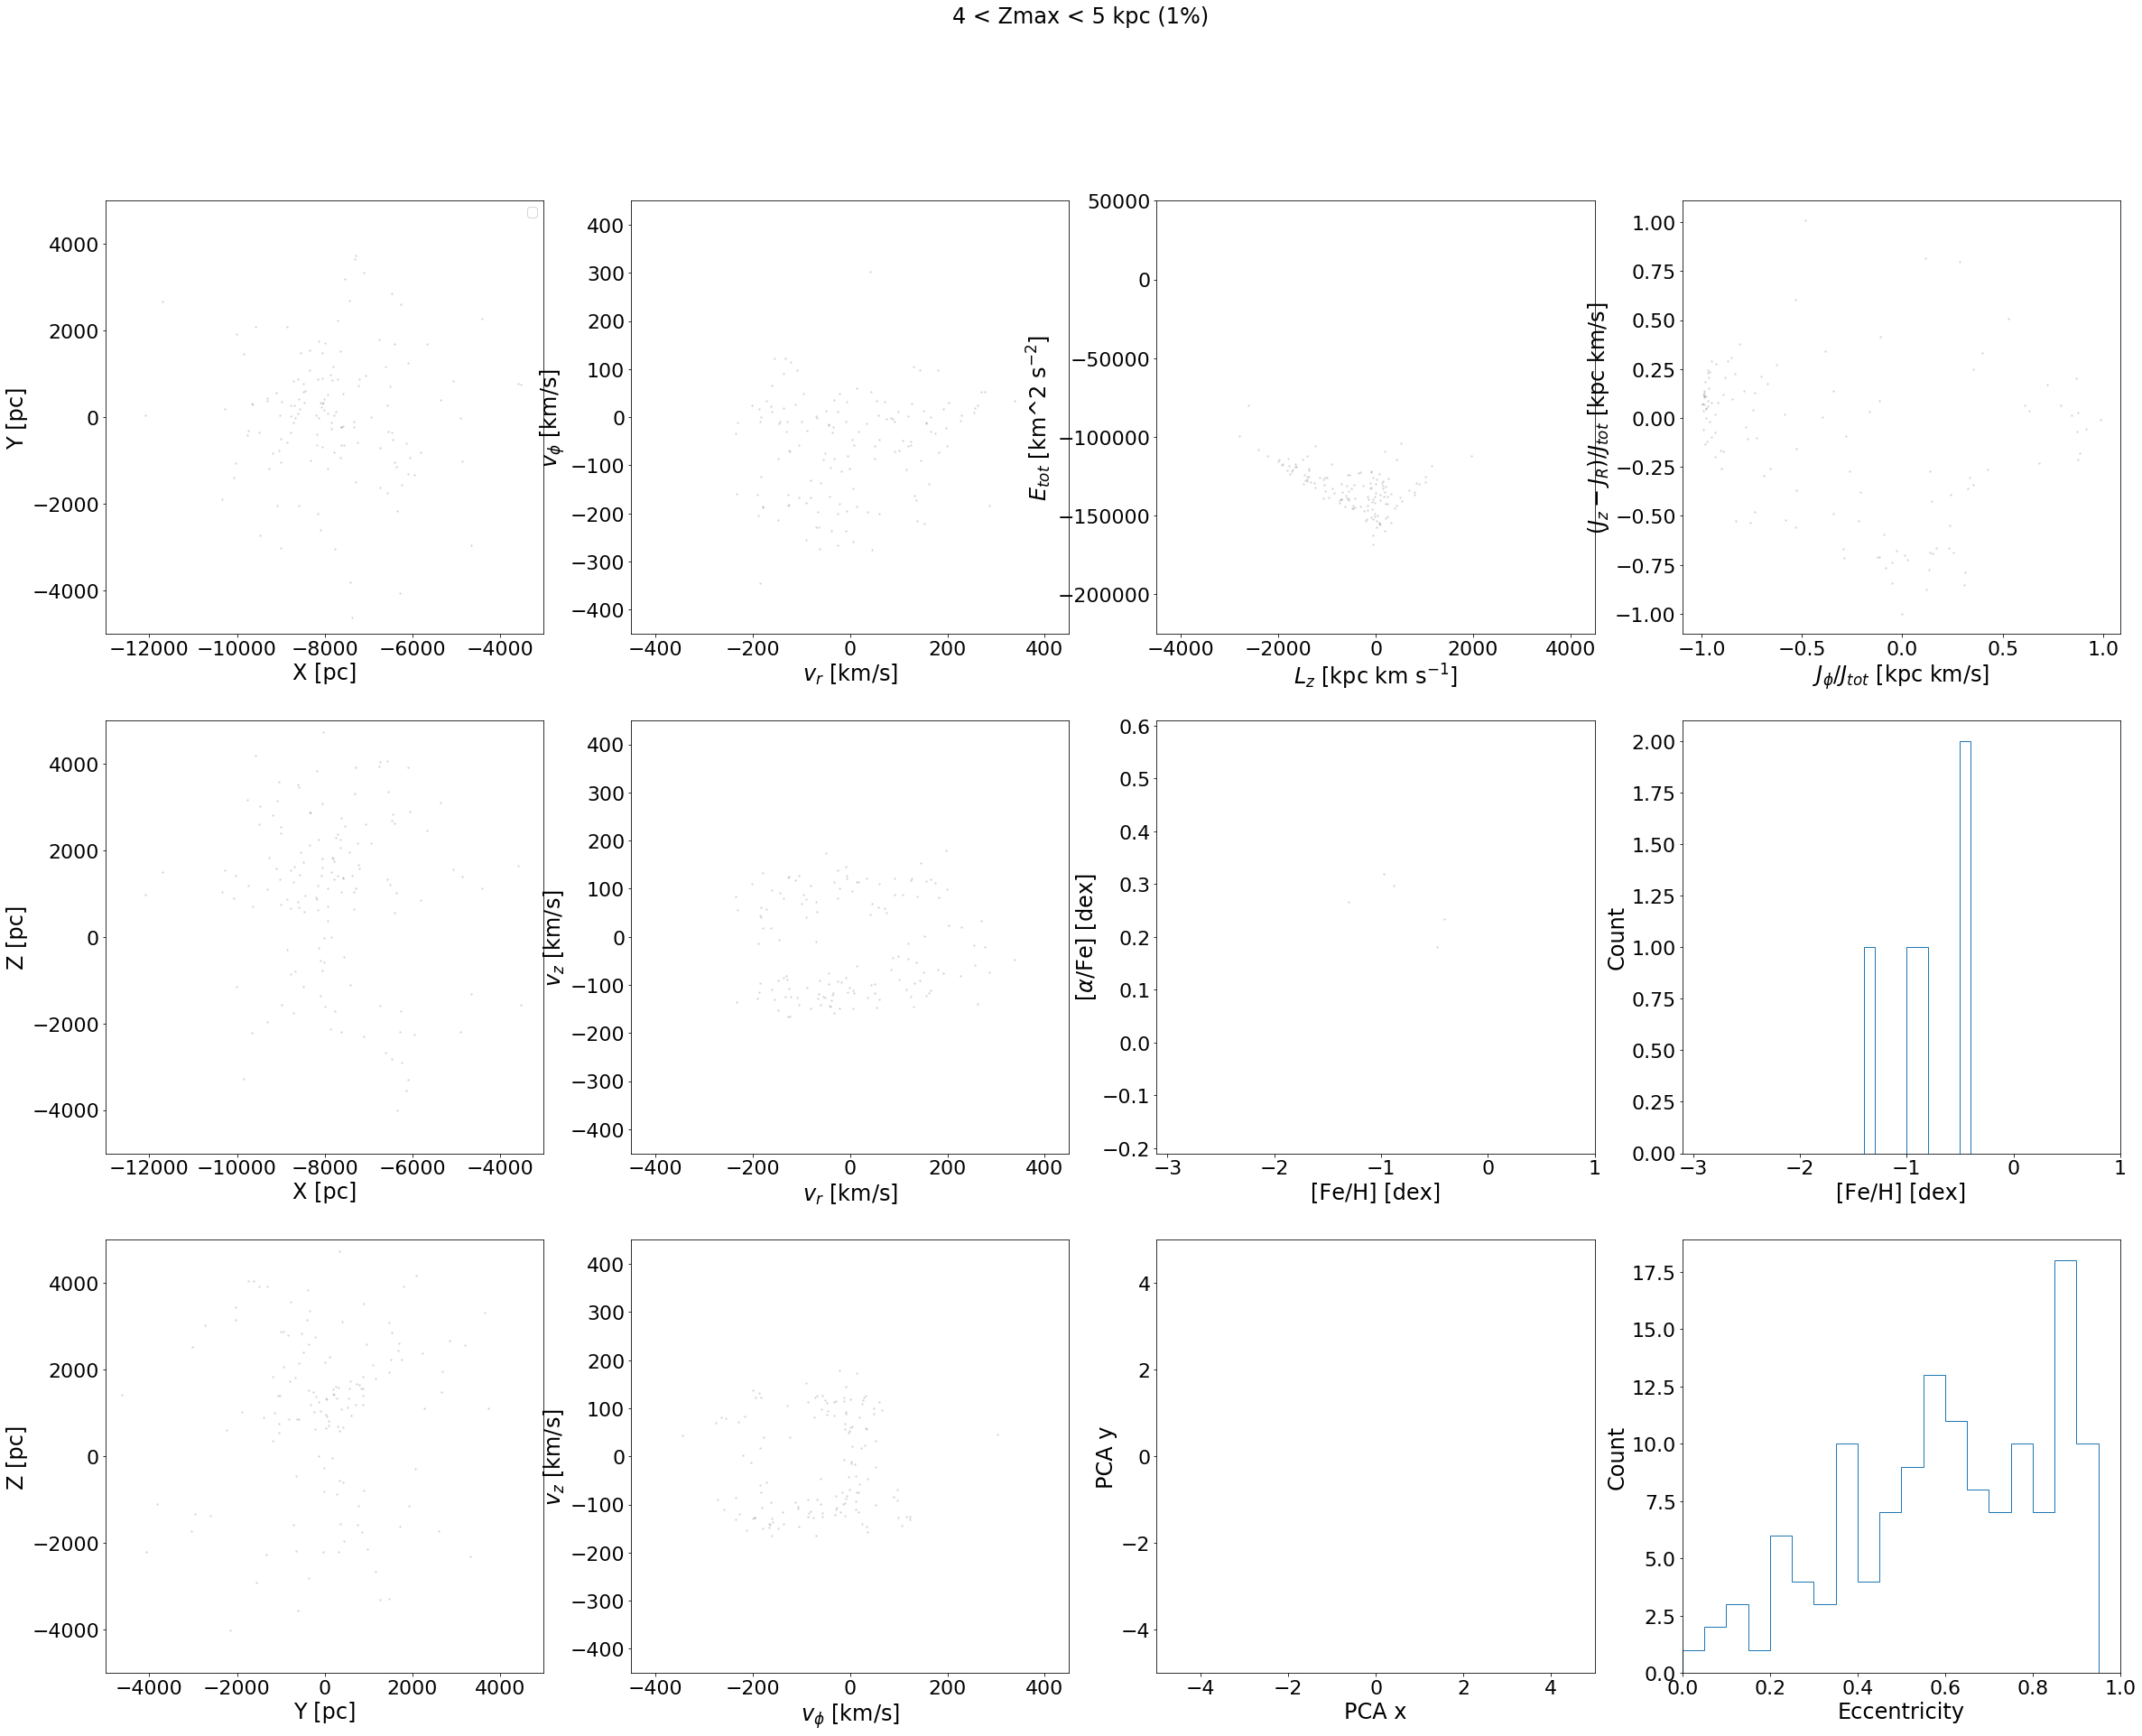

In [65]:
# Make summary plot of the all the stars currently in the sample given the zmax cut
# Apply down sampling as neccessary
# ii = np.arange(len(ind_cut))
ii = np.random.choice(len(ind_cut),int(len(ind_cut)/100),replace=False)

plot_summary(df_cut_vel,df_cut_orb,ind_list=[ii],c_list=['k'],
             title='4 < Zmax < 5 kpc (1%)',legends=[''],list_mask=True,
             filename='./zmax_g4_l5_100th_gaia_only.png',bg=True,ds=False)

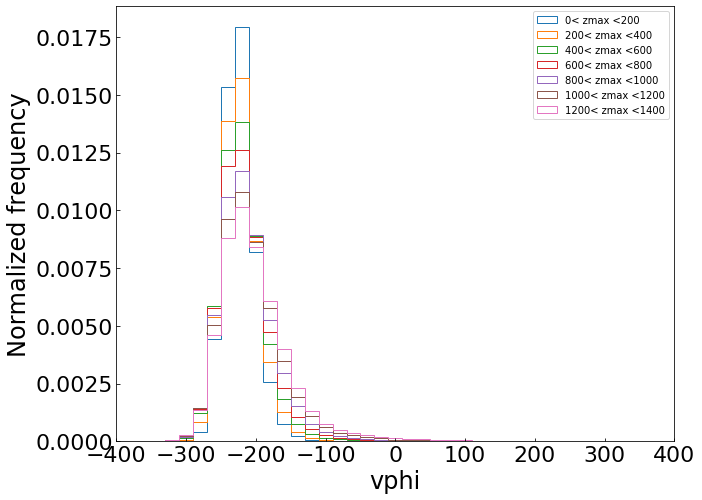

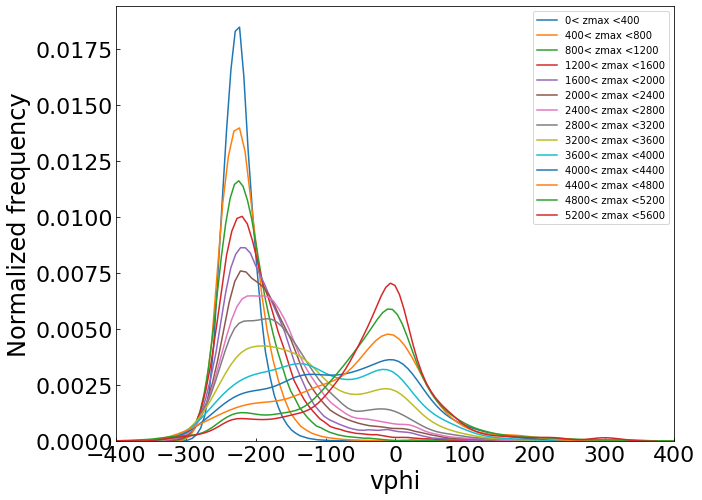

In [60]:
import seaborn as sns

# Make vphi histogram plots to examine if there's a transition from thin disk to thick disk
f1 = plt.figure(figsize=[10,8])
vphi_bin = np.arange(-450,450,20)

# Create a list for zmax cut bounds
cutoff_l_arr = np.arange(0,1300,200)
cutoff_h_arr = np.arange(200,1500,200)

for i in range(len(cutoff_l_arr)):
    selection = ((abs(orb_param_all['zmax']) > cutoff_l_arr[i]) & (abs(orb_param_all['zmax']) < cutoff_h_arr[i]))
    combined_cut = kin_qual & selection
    ind_cut = np.where(combined_cut)[0]
    plt.hist(cm_vel_all.loc[ind_cut,'best_vphi'],density=True,histtype='step',bins=vphi_bin, label=str(cutoff_l_arr[i])+'< zmax <'+str(cutoff_h_arr[i]))

plt.legend()
plt.xlabel('vphi',fontsize=24)
plt.ylabel('Normalized frequency',fontsize=24)
plt.xlim([-400,400])
plt.show()

# Make vphi density plots to examine if there's a transition from thin disk to thick disk
f2 = plt.figure(figsize=[10,8])
vphi_bin = np.arange(-450,450,20)

# Create a list for zmax cut bounds
cutoff_l_arr = np.arange(0,5400,400)
cutoff_h_arr = np.arange(400,5800,400)

for i in range(len(cutoff_l_arr)):
    selection = ((abs(orb_param_all['zmax']) > cutoff_l_arr[i]) & (abs(orb_param_all['zmax']) < cutoff_h_arr[i]))
    combined_cut = kin_qual & selection
    ind_cut = np.where(combined_cut)[0]
    sns.distplot(cm_vel_all.loc[ind_cut,'best_vphi'],hist=False,kde=True,bins=vphi_bin, label=str(cutoff_l_arr[i])+'< zmax <'+str(cutoff_h_arr[i]))

plt.legend()
plt.xlabel('vphi',fontsize=24)
plt.ylabel('Normalized frequency',fontsize=24)
plt.xlim([-400,400])
plt.show()

# f2.savefig('./vphi_hist_zmax_int_gaia2.png')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


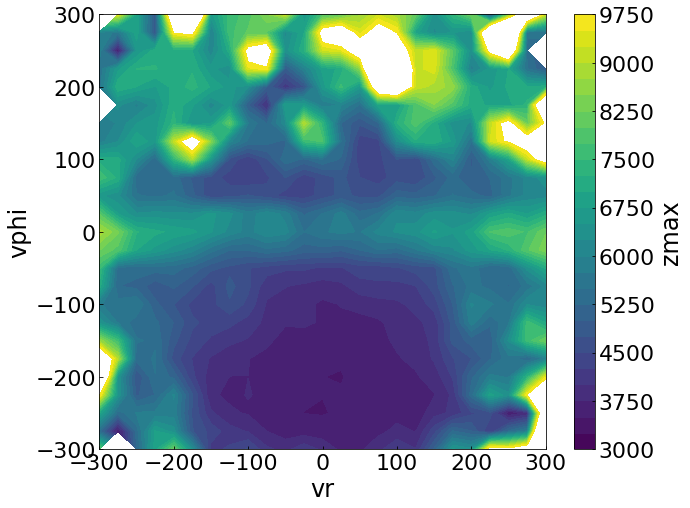

In [31]:
# Plot 2d density plots in vr vs. vphi plane at constant zmax or [Fe/H]
f = plt.figure(figsize=[10,8])

Xdata = df_cut_vel['best_vr'].values
Ydata = df_cut_vel['best_vphi'].values
Zdata = abs(df_cut_orb['zmax'].values)

Xgridsize = 25
Ygridsize = 25
Zlevels = np.arange(3000,10000,250)

Xgrid, Ygrid = np.meshgrid(np.arange(-300, 350, Xgridsize), np.arange(-300, 350, Ygridsize))
Xgrid, Ygrid = Xgrid.T, Ygrid.T
Zgrid = np.empty(np.shape(Xgrid))*np.nan

# Calculate the average zmax in the region
for i in range(len(Xgrid)):
    for j in range(len(Ygrid)):
        xlim = Xgrid[i,0] + np.array([-Xgridsize,Xgridsize])
        ylim = Ygrid[0,j] + np.array([-Ygridsize,Ygridsize])
        
        ii_tmp = np.where((Xdata < xlim[1]) & (Xdata > xlim[0]) &
                          (Ydata < ylim[1]) & (Ydata > ylim[0])
                         )[0]
        
        Zgrid[i,j] = np.nanmean(Zdata[ii_tmp])

CS = plt.contourf(Xgrid,Ygrid,Zgrid,levels=Zlevels)
cbar = f.colorbar(CS)
cbar.ax.set_ylabel('zmax',fontsize=lable_size)
plt.xlabel('vr',fontsize=24)
plt.ylabel('vphi',fontsize=24)
plt.xlim([-300,300])
plt.ylim([-300,300])
plt.show()

f.savefig('./vphi_vr_zmax_contour_gaia2_zmax3.png')

In [39]:
A = [np.nan]*5
A[2] = np.ones(10)
print(A)

[nan, nan, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), nan, nan]


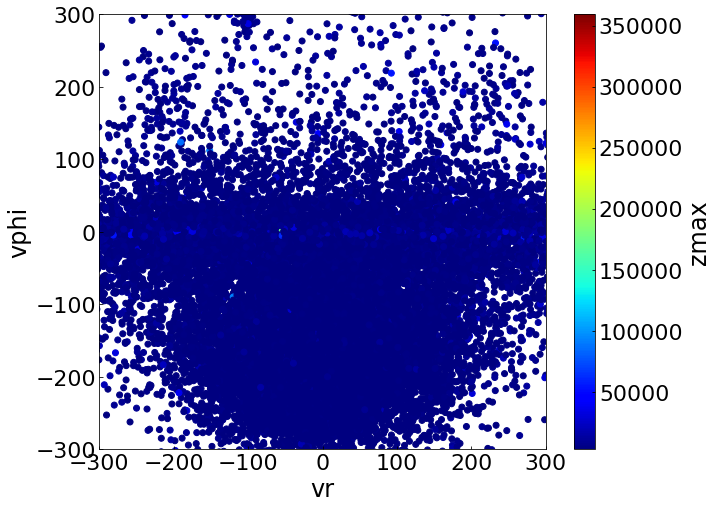

In [32]:
# Plot scatter plots in vr vs. vphi plane with colorcode by zmax or [Fe/H]
f = plt.figure(figsize=[10,8])

Xdata = df_cut_vel['best_vr'].values
Ydata = df_cut_vel['best_vphi'].values
Zdata = abs(df_cut_orb['zmax'].values)
Zcolors = Zdata/(np.max(Zdata)-np.min(Zdata))


CS = plt.scatter(Xdata,Ydata,c=Zdata,cmap=matplotlib.cm.jet)
cbar = f.colorbar(CS)
cbar.ax.set_ylabel('zmax',fontsize=lable_size)
plt.xlabel('vr',fontsize=24)
plt.ylabel('vphi',fontsize=24)
plt.xlim([-300,300])
plt.ylim([-300,300])
plt.show()

f.savefig('./vphi_vr_zmax_scatter_gaia2_zmax3.png')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


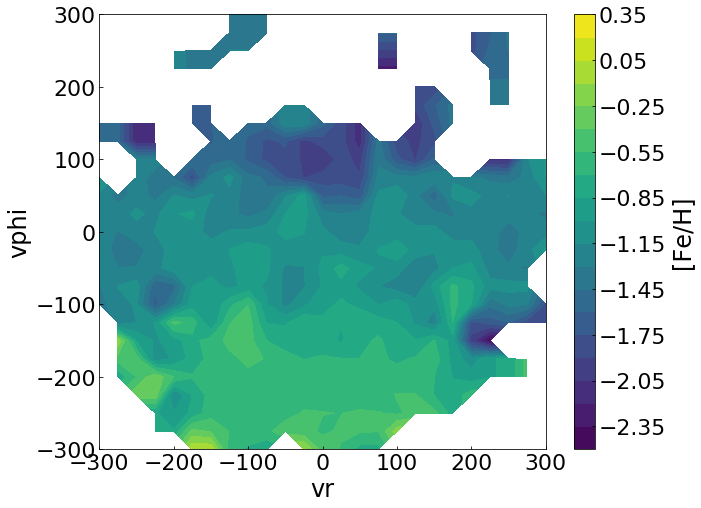

In [15]:
# Plot 2d density plots in vr vs. vphi plane at constant zmax or [Fe/H]
f = plt.figure(figsize=[10,8])

Xdata = df_cut_vel['best_vr'].values
Ydata = df_cut_vel['best_vphi'].values
Zdata = df_cut_vel['m_h_ap'].values

Xgridsize = 25
Ygridsize = 25
Zlevels = np.arange(-2.5,0.5,0.15)

Xgrid, Ygrid = np.meshgrid(np.arange(-300, 350, Xgridsize), np.arange(-300, 350, Ygridsize))
Xgrid, Ygrid = Xgrid.T, Ygrid.T
Zgrid = np.empty(np.shape(Xgrid))*np.nan

# Calculate the average zmax in the region
for i in range(len(Xgrid)):
    for j in range(len(Ygrid)):
        xlim = Xgrid[i,0] + np.array([-Xgridsize,Xgridsize])
        ylim = Ygrid[0,j] + np.array([-Ygridsize,Ygridsize])
        
        ii_tmp = np.where((Xdata < xlim[1]) & (Xdata > xlim[0]) &
                          (Ydata < ylim[1]) & (Ydata > ylim[0])
                         )[0]
        
        Zgrid[i,j] = np.nanmean(Zdata[ii_tmp])

CS = plt.contourf(Xgrid,Ygrid,Zgrid,levels=Zlevels)
cbar = f.colorbar(CS)
cbar.ax.set_ylabel('[Fe/H]',fontsize=lable_size)
plt.xlabel('vr',fontsize=24)
plt.ylabel('vphi',fontsize=24)
plt.xlim([-300,300])
plt.ylim([-300,300])
plt.show()

f.savefig('./vphi_vr_feh_contour_gaia2_zmax3.png')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


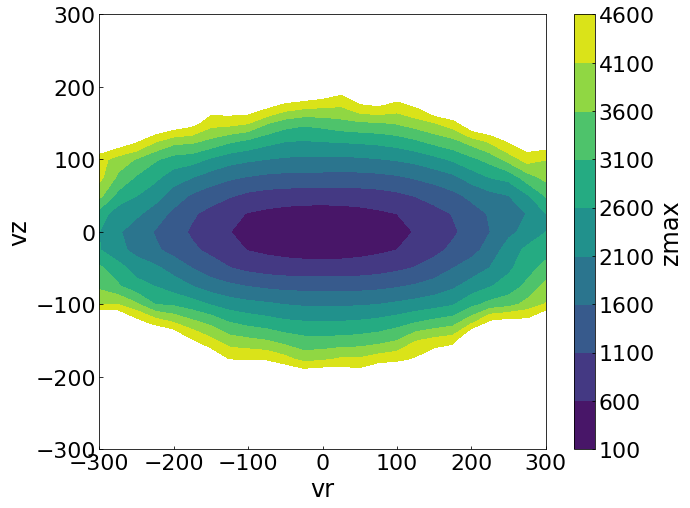

In [65]:
# Plot 2d density plots in vz vs. vphi plane at constant zmax or [Fe/H]
f = plt.figure(figsize=[10,8])

Xdata = df_cut_vel['best_vr'].values
Ydata = df_cut_vel['best_vz'].values
Zdata = df_cut_orb['zmax'].values

Xgridsize = 25
Ygridsize = 25
Zlevels = np.arange(100,5000,500)

Xgrid, Ygrid = np.meshgrid(np.arange(-300, 350, Xgridsize), np.arange(-300, 350, Ygridsize))
Xgrid, Ygrid = Xgrid.T, Ygrid.T
Zgrid = np.empty(np.shape(Xgrid))*np.nan

# Calculate the average zmax in the region
for i in range(len(Xgrid)):
    for j in range(len(Ygrid)):
        xlim = Xgrid[i,0] + np.array([-Xgridsize,Xgridsize])
        ylim = Ygrid[0,j] + np.array([-Ygridsize,Ygridsize])
        
        ii_tmp = np.where((Xdata < xlim[1]) & (Xdata > xlim[0]) &
                          (Ydata < ylim[1]) & (Ydata > ylim[0])
                         )[0]
        
        Zgrid[i,j] = np.nanmean(Zdata[ii_tmp])

CS = plt.contourf(Xgrid,Ygrid,Zgrid,levels=Zlevels)
cbar = f.colorbar(CS)
cbar.ax.set_ylabel('zmax',fontsize=lable_size)
plt.xlabel('vr',fontsize=24)
plt.ylabel('vz',fontsize=24)
plt.xlim([-300,300])
plt.ylim([-300,300])
plt.show()

f.savefig('./vz_vr_zmax_contour_gaia2.png')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


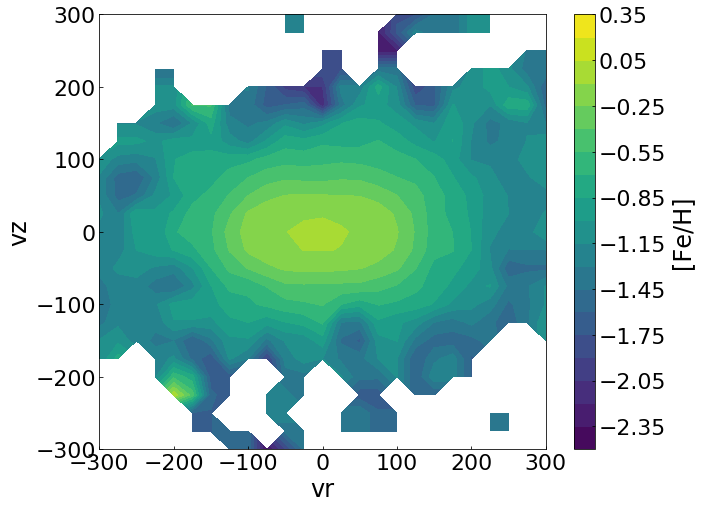

In [72]:
# Plot 2d density plots in vr vs. vz plane at constant zmax or [Fe/H]
f = plt.figure(figsize=[10,8])

Xdata = df_cut_vel['best_vr'].values
Ydata = df_cut_vel['best_vz'].values
Zdata = df_cut_vel['m_h_ap'].values

Xgridsize = 25
Ygridsize = 25
Zlevels = np.arange(-2.5,0.5,0.15)

Xgrid, Ygrid = np.meshgrid(np.arange(-300, 350, Xgridsize), np.arange(-300, 350, Ygridsize))
Xgrid, Ygrid = Xgrid.T, Ygrid.T
Zgrid = np.empty(np.shape(Xgrid))*np.nan

# Calculate the average zmax in the region
for i in range(len(Xgrid)):
    for j in range(len(Ygrid)):
        xlim = Xgrid[i,0] + np.array([-Xgridsize,Xgridsize])
        ylim = Ygrid[0,j] + np.array([-Ygridsize,Ygridsize])
        
        ii_tmp = np.where((Xdata < xlim[1]) & (Xdata > xlim[0]) &
                          (Ydata < ylim[1]) & (Ydata > ylim[0])
                         )[0]
        
        Zgrid[i,j] = np.nanmean(Zdata[ii_tmp])

CS = plt.contourf(Xgrid,Ygrid,Zgrid,levels=Zlevels)
cbar = f.colorbar(CS)
cbar.ax.set_ylabel('[Fe/H]',fontsize=lable_size)
plt.xlabel('vr',fontsize=24)
plt.ylabel('vz',fontsize=24)
plt.xlim([-300,300])
plt.ylim([-300,300])
plt.show()

f.savefig('./vz_vr_feh_contour_gaia2.png')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


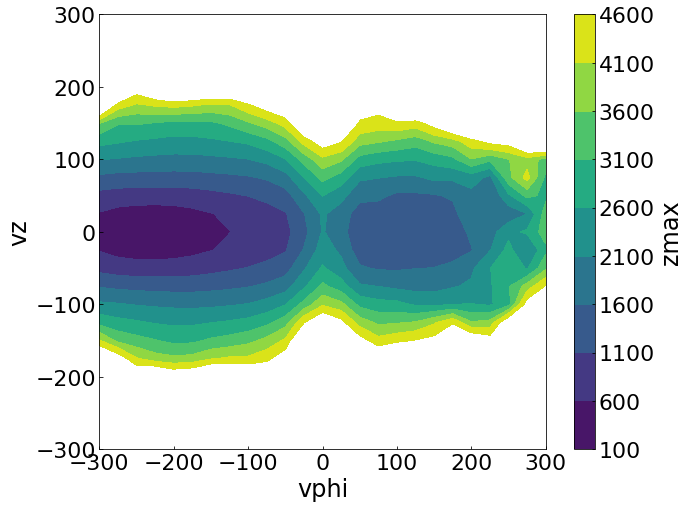

In [73]:
# Plot 2d density plots in vz vs. vphi plane at constant zmax or [Fe/H]
f = plt.figure(figsize=[10,8])

Xdata = df_cut_vel['best_vphi'].values
Ydata = df_cut_vel['best_vz'].values
Zdata = df_cut_orb['zmax'].values

Xgridsize = 25
Ygridsize = 25
Zlevels = np.arange(100,5000,500)

Xgrid, Ygrid = np.meshgrid(np.arange(-300, 350, Xgridsize), np.arange(-300, 350, Ygridsize))
Xgrid, Ygrid = Xgrid.T, Ygrid.T
Zgrid = np.empty(np.shape(Xgrid))*np.nan

# Calculate the average zmax in the region
for i in range(len(Xgrid)):
    for j in range(len(Ygrid)):
        xlim = Xgrid[i,0] + np.array([-Xgridsize,Xgridsize])
        ylim = Ygrid[0,j] + np.array([-Ygridsize,Ygridsize])
        
        ii_tmp = np.where((Xdata < xlim[1]) & (Xdata > xlim[0]) &
                          (Ydata < ylim[1]) & (Ydata > ylim[0])
                         )[0]
        
        Zgrid[i,j] = np.nanmean(Zdata[ii_tmp])

CS = plt.contourf(Xgrid,Ygrid,Zgrid,levels=Zlevels)
cbar = f.colorbar(CS)
cbar.ax.set_ylabel('zmax',fontsize=lable_size)
plt.xlabel('vphi',fontsize=24)
plt.ylabel('vz',fontsize=24)
plt.xlim([-300,300])
plt.ylim([-300,300])
plt.show()

f.savefig('./vz_vphi_zmax_contour_gaia2.png')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


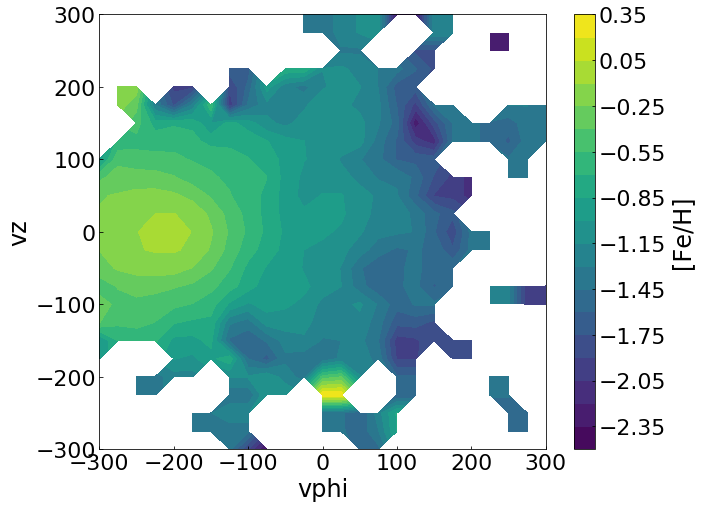

In [74]:
# Plot 2d density plots in vz vs. vphi plane at constant zmax or [Fe/H]
f = plt.figure(figsize=[10,8])

Xdata = df_cut_vel['best_vphi'].values
Ydata = df_cut_vel['best_vz'].values
Zdata = df_cut_vel['m_h_ap'].values

Xgridsize = 25
Ygridsize = 25
Zlevels = np.arange(-2.5,0.5,0.15)

Xgrid, Ygrid = np.meshgrid(np.arange(-300, 350, Xgridsize), np.arange(-300, 350, Ygridsize))
Xgrid, Ygrid = Xgrid.T, Ygrid.T
Zgrid = np.empty(np.shape(Xgrid))*np.nan

# Calculate the average zmax in the region
for i in range(len(Xgrid)):
    for j in range(len(Ygrid)):
        xlim = Xgrid[i,0] + np.array([-Xgridsize,Xgridsize])
        ylim = Ygrid[0,j] + np.array([-Ygridsize,Ygridsize])
        
        ii_tmp = np.where((Xdata < xlim[1]) & (Xdata > xlim[0]) &
                          (Ydata < ylim[1]) & (Ydata > ylim[0])
                         )[0]
        
        Zgrid[i,j] = np.nanmean(Zdata[ii_tmp])

CS = plt.contourf(Xgrid,Ygrid,Zgrid,levels=Zlevels)
cbar = f.colorbar(CS)
cbar.ax.set_ylabel('[Fe/H]',fontsize=lable_size)
plt.xlabel('vphi',fontsize=24)
plt.ylabel('vz',fontsize=24)
plt.xlim([-300,300])
plt.ylim([-300,300])
plt.show()

f.savefig('./vz_vphi_feh_contour_gaia2.png')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


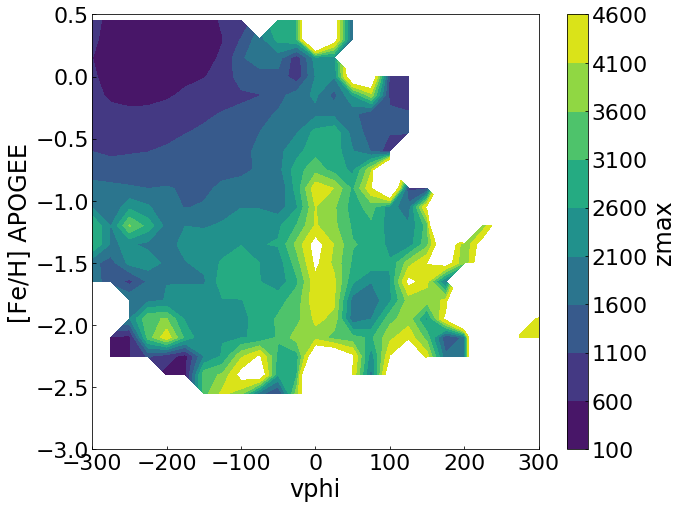

In [78]:
# Plot 2d density plots in [Fe/H] vs. vphi plane at constant zmax or [Fe/H]
f = plt.figure(figsize=[10,8])

Xdata = df_cut_vel['best_vphi'].values
Ydata = df_cut_vel['m_h_ap'].values
Zdata = df_cut_orb['zmax'].values

Xgridsize = 25
Ygridsize = 0.15
Zlevels = np.arange(100,5000,500)

Xgrid, Ygrid = np.meshgrid(np.arange(-300, 350, Xgridsize), np.arange(-3., 0.5, Ygridsize))
Xgrid, Ygrid = Xgrid.T, Ygrid.T
Zgrid = np.empty(np.shape(Xgrid))*np.nan

# Calculate the average zmax in the region
for i in range(len(Xgrid)):
    for j in range(len(Ygrid[0])):
        xlim = Xgrid[i,0] + np.array([-Xgridsize,Xgridsize])
        ylim = Ygrid[0,j] + np.array([-Ygridsize,Ygridsize])
        
        ii_tmp = np.where((Xdata < xlim[1]) & (Xdata > xlim[0]) &
                          (Ydata < ylim[1]) & (Ydata > ylim[0])
                         )[0]
        
        Zgrid[i,j] = np.nanmean(Zdata[ii_tmp])

CS = plt.contourf(Xgrid,Ygrid,Zgrid,levels=Zlevels)
cbar = f.colorbar(CS)
cbar.ax.set_ylabel('zmax',fontsize=lable_size)
plt.xlabel('vphi',fontsize=24)
plt.ylabel('[Fe/H] APOGEE',fontsize=24)
plt.xlim([-300,300])
plt.ylim([-3,0.5])
plt.show()

f.savefig('./feh_vphi_zmax_contour_gaia2.png')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


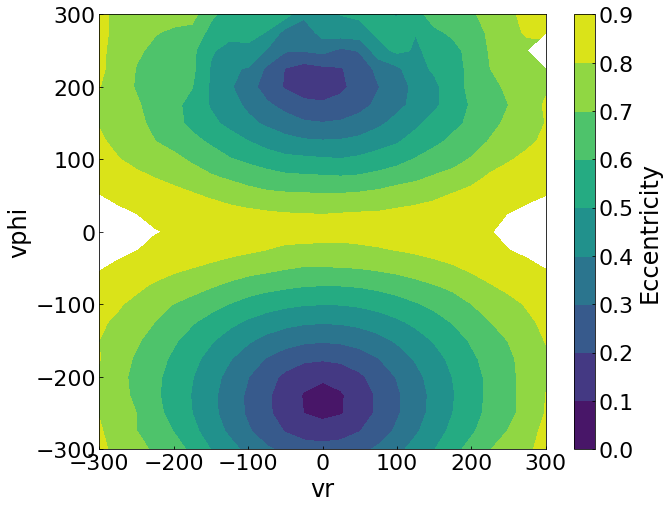

In [35]:
# Plot 2d density plots in vr vs. vphi plane at constant ecc
f = plt.figure(figsize=[10,8])

Xdata = df_cut_vel['best_vr'].values
Ydata = df_cut_vel['best_vphi'].values
Zdata = df_cut_orb['ecc'].values

Xgridsize = 25
Ygridsize = 25
Zlevels = np.arange(0,1,0.1)

Xgrid, Ygrid = np.meshgrid(np.arange(-300, 350, Xgridsize), np.arange(-300, 350, Ygridsize))
Xgrid, Ygrid = Xgrid.T, Ygrid.T
Zgrid = np.empty(np.shape(Xgrid))*np.nan

# Calculate the average zmax in the region
for i in range(len(Xgrid)):
    for j in range(len(Ygrid)):
        xlim = Xgrid[i,0] + np.array([-Xgridsize,Xgridsize])
        ylim = Ygrid[0,j] + np.array([-Ygridsize,Ygridsize])
        
        ii_tmp = np.where((Xdata < xlim[1]) & (Xdata > xlim[0]) &
                          (Ydata < ylim[1]) & (Ydata > ylim[0])
                         )[0]
        
        Zgrid[i,j] = np.nanmean(Zdata[ii_tmp])

CS = plt.contourf(Xgrid,Ygrid,Zgrid,levels=Zlevels)
cbar = f.colorbar(CS)
cbar.ax.set_ylabel('Eccentricity',fontsize=lable_size)
plt.xlabel('vr',fontsize=24)
plt.ylabel('vphi',fontsize=24)
plt.xlim([-300,300])
plt.ylim([-300,300])
plt.show()

f.savefig('./vphi_vr_ecc_contour_gaia2.png')